# CNN

<img src="https://www.ecovis.com/heidelberg-de/wp-content/uploads/2025/09/AdobeStock_425918469_djvstock-scaled.jpeg" width=750>

### Introduction

Facial keypoint detection is an important computer vision task used in areas such as face recognition, emotion analysis, and human–computer interaction.
The goal of this project is to predict 30 facial keypoint coordinates from 96×96 grayscale face images.

To solve this task, a custom Convolutional Neural Network (CNN) was designed and trained from scratch.
The project covers the full deep learning workflow, including data preprocessing, model design, training, evaluation, visualization, and deployment.

### Import Libraries

In [55]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import zipfile
import os
from collections import Counter
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import tensorflow as tf
import pickle
import json
import warnings
warnings.filterwarnings("ignore")  

### Load Data

In [21]:
import kagglehub, os

data_path = kagglehub.competition_download('facial-keypoints-detection')
print('DATA PATH:', data_path)
print('FILES:', os.listdir(data_path))


100%|██████████████████████████████████████████████████████████████████████████████| 76.3M/76.3M [00:12<00:00, 6.32MB/s]

Extracting files...


DATA PATH: /root/.cache/kagglehub/competitions/facial-keypoints-detection
FILES: ['training.zip', 'IdLookupTable.csv', 'test.zip', 'SampleSubmission.csv']


In [27]:
for z in ['training.zip', 'test.zip']:
    with zipfile.ZipFile(os.path.join(data_path, z), 'r') as zip_ref:
        zip_ref.extractall(data_path)

print(os.listdir(data_path))

['training.zip', 'IdLookupTable.csv', 'test.zip', 'training.csv', 'test.csv', 'SampleSubmission.csv']


In [28]:
train_df=pd.read_csv(f'{data_path}/training.csv')
test_df=pd.read_csv(f'{data_path}/test.csv')
lookup_df=pd.read_csv(f'{data_path}/IdLookupTable.csv')

print('train:', train_df.shape)
print('test :', test_df.shape)
print('lookup:', lookup_df.shape)

train: (7049, 31)
test : (1783, 2)
lookup: (27124, 4)


In [38]:
target_cols=train_df.columns.drop('Image').tolist()
print('n_targets:', len(target_cols))

n_targets: 30


In [39]:
print(set(lookup_df['FeatureName']) - set(target_cols))

set()


### EDA

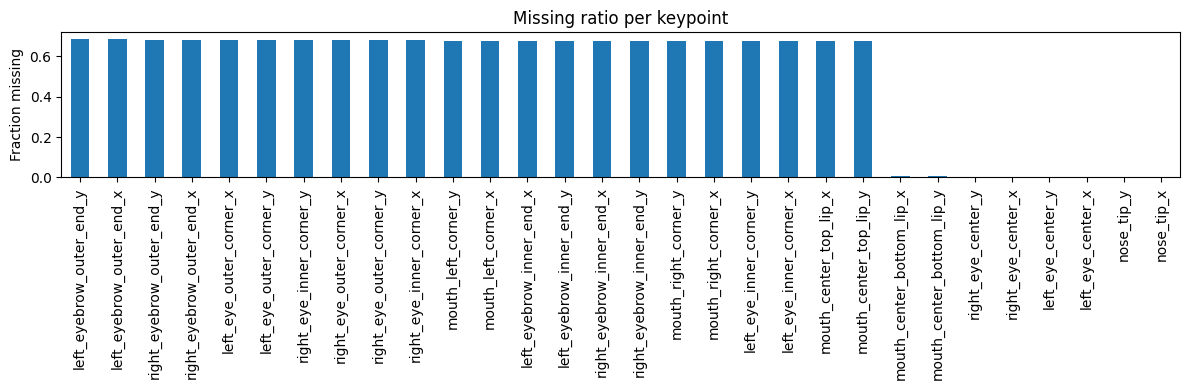

In [40]:
missing=train_df[target_cols].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(12,4))
missing.plot(kind='bar')
plt.title('Missing ratio per keypoint')
plt.ylabel('Fraction missing')
plt.tight_layout()
plt.show()

Most facial keypoints have a high amount of missing values, while only a few keypoints are almost always labeled.

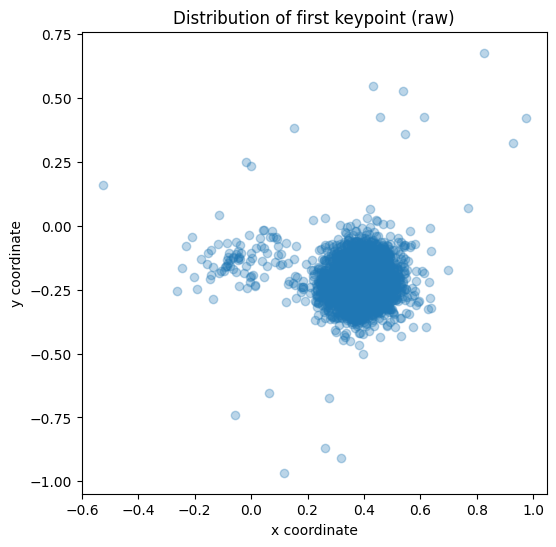

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(y[:,0], y[:,1], alpha=0.3)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Distribution of first keypoint (raw)')
plt.show()

The first facial keypoint shows a clear cluster in the center of the image, with some outliers at the edges.

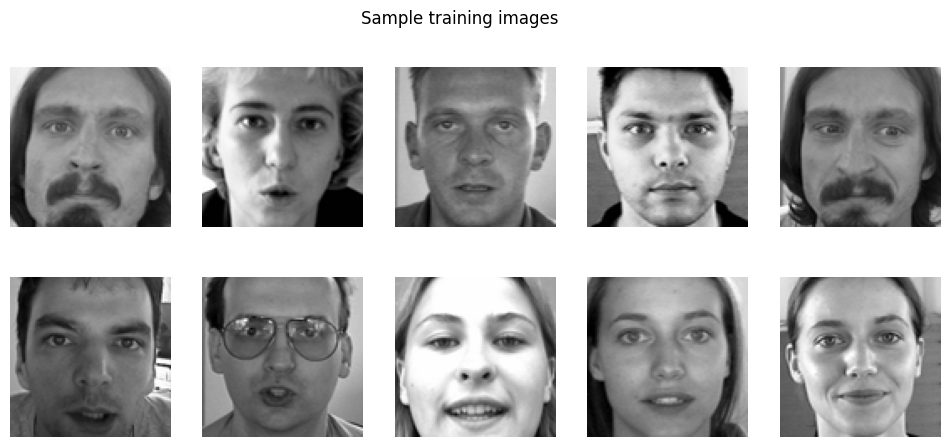

In [42]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Sample training images')
plt.show()

The sample images show grayscale face images with consistent alignment and similar resolution.

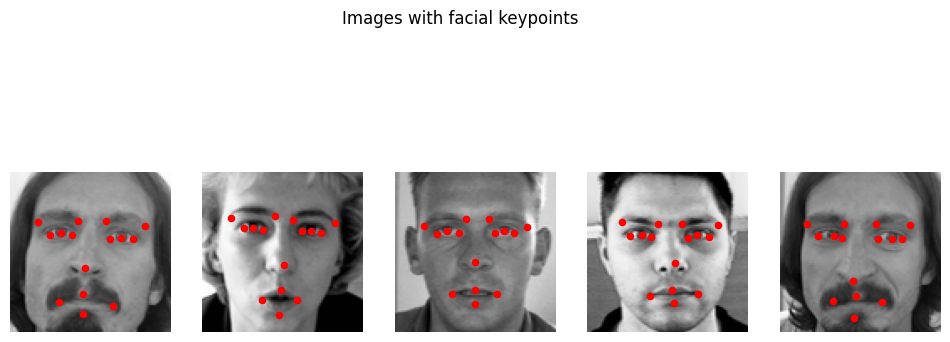

In [43]:
def plot_image_with_keypoints(img, keypoints):
    plt.imshow(img.squeeze(), cmap='gray')
    xs = keypoints[0::2] * 48 + 48
    ys = keypoints[1::2] * 48 + 48
    plt.scatter(xs, ys, c='red', s=20)
    plt.axis('off')

plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image_with_keypoints(x_c[i], y_c[i])
plt.suptitle('Images with facial keypoints')
plt.show()

The red dots confirm that the labeled keypoints are well aligned with facial features such as eyes, nose, and mouth

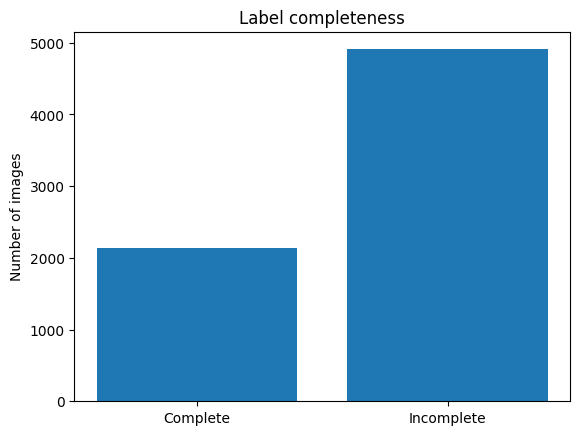

In [44]:
complete = (~np.isnan(y).any(axis=1)).sum()
incomplete = y.shape[0] - complete

plt.bar(['Complete', 'Incomplete'], [complete, incomplete])
plt.title('Label completeness')
plt.ylabel('Number of images')
plt.show()

Only a small portion of images contains all keypoints, while most images have missing labels.

### Data Preprocessing & Normalization

In [34]:
def parse_image(img_str):
    pixels = np.fromstring(img_str, sep=' ', dtype=np.float32)
    return pixels.reshape(96, 96, 1)

train_df=train_df.dropna(subset=['Image']).reset_index(drop=True)

x=np.stack(train_df['Image'].apply(parse_image).values)
y=train_df[target_cols].values.astype(np.float32)

print('x:', x.shape, x.dtype)
print('y:', y.shape, y.dtype)

x: (7049, 96, 96, 1) float32
y: (7049, 30) float32


In [35]:
x=x / 255.0
y=(y - 48.0) / 48.0 

In [36]:
mask= ~np.isnan(y).any(axis=1)
x_c=x[mask]
y_c=y[mask]

print('complete:', x_c.shape[0], '/', x.shape[0])

complete: 2140 / 7049


In [37]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

### CNN Model Architecture

In [45]:
model=Sequential()

model.add(Input(shape=(96, 96, 1)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dropout(0.3))
model.add(Dense(30, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                        

I0000 00:00:1766942272.095973     262 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1766942272.413039     262 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1766942272.413097     262 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1766942272.417885     262 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1766942272.417922     262 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MSE,metrics=[rmse, tf.keras.metrics.MAE])

In [47]:
early_stop=EarlyStopping(monitor='val_rmse',patience=12,restore_best_weights=True,mode='min',verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_rmse',factor=0.5,patience=5,min_lr=1e-6,mode='min',verbose=1)
checkpoint=ModelCheckpoint('best_keypoints_cnn.keras',monitor='val_rmse',save_best_only=True,mode='min',verbose=1)

### Model Training

In [48]:
x_train,x_val,y_train,y_val=train_test_split(x_c, y_c,test_size=0.2,random_state=42)

In [49]:
history=model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=200,batch_size=32,callbacks=[early_stop, reduce_lr, checkpoint],verbose=1)

Epoch 1/200


2025-12-28 17:18:05.257897: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1766942285.491868     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.520221     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.524678     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.529056     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.533661     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.553431     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.576901     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942285.597642     536 gpu_

 1/54 [..............................] - ETA: 3:37 - loss: 0.3203 - rmse: 0.5350 - mean_absolute_error: 0.4375

W0000 00:00:1766942287.817709     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942287.829562     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942287.848183     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1766942287.927459     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942287.929501     534 gpu_timer.cc:114] Skipping the delay kernel, measu

 2/54 [>.............................] - ETA: 19s - loss: 0.2639 - rmse: 0.4758 - mean_absolute_error: 0.3868 

W0000 00:00:1766942288.230640     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.231373     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.233071     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.234861     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.237498     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.239616     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.248968     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.249535     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.250013     535 gp

 3/54 [>.............................] - ETA: 14s - loss: 0.2420 - rmse: 0.4523 - mean_absolute_error: 0.3649

W0000 00:00:1766942288.431694     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.433587     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.435143     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.436704     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.438103     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.439805     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.440528     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.442260     538 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.444103     538 gp

12/54 [=====>........................] - ETA: 3s - loss: 0.1686 - rmse: 0.3611 - mean_absolute_error: 0.2888 

W0000 00:00:1766942288.632922     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.634289     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.636163     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.637754     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.639422     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.641135     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.642839     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.643545     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942288.645316     534 gp

54/54 [==============================] - ETA: 0s - loss: 0.1118 - rmse: 0.2717 - mean_absolute_error: 0.2166

W0000 00:00:1766942289.357903     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.358139     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.358312     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.358568     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.358780     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.359220     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.359567     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.359967     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.360220     532 gp


Epoch 1: val_rmse improved from inf to 0.25469, saving model to best_keypoints_cnn.keras
54/54 [==============================] - 6s 39ms/step - loss: 0.1118 - rmse: 0.2717 - mean_absolute_error: 0.2166 - val_loss: 0.0986 - val_rmse: 0.2547 - val_mean_absolute_error: 0.2126 - lr: 1.0000e-04
Epoch 2/200
 1/54 [..............................] - ETA: 0s - loss: 0.0714 - rmse: 0.1938 - mean_absolute_error: 0.1543

W0000 00:00:1766942289.813703     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.813919     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.814062     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.814245     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.814419     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.814802     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.814997     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.815256     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942289.815455     535 gp

54/54 [==============================] - ETA: 0s - loss: 0.0723 - rmse: 0.1961 - mean_absolute_error: 0.1556

W0000 00:00:1766942290.638222     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.638460     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.638635     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.638877     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.639101     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.639528     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.639829     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.640160     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.640391     535 gp


Epoch 2: val_rmse improved from 0.25469 to 0.19306, saving model to best_keypoints_cnn.keras
54/54 [==============================] - 1s 19ms/step - loss: 0.0723 - rmse: 0.1961 - mean_absolute_error: 0.1556 - val_loss: 0.0708 - val_rmse: 0.1931 - val_mean_absolute_error: 0.1522 - lr: 1.0000e-04
Epoch 3/200
 1/54 [..............................] - ETA: 0s - loss: 0.0654 - rmse: 0.1782 - mean_absolute_error: 0.1425

W0000 00:00:1766942290.887094     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.887349     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.887572     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.887817     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.888042     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.888477     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.888692     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.888959     537 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942290.889229     537 gp

54/54 [==============================] - ETA: 0s - loss: 0.0633 - rmse: 0.1726 - mean_absolute_error: 0.1365
Epoch 3: val_rmse improved from 0.19306 to 0.18631, saving model to best_keypoints_cnn.keras
54/54 [==============================] - 1s 15ms/step - loss: 0.0633 - rmse: 0.1726 - mean_absolute_error: 0.1365 - val_loss: 0.0681 - val_rmse: 0.1863 - val_mean_absolute_error: 0.1574 - lr: 1.0000e-04
Epoch 4/200
 1/54 [..............................] - ETA: 0s - loss: 0.0598 - rmse: 0.1625 - mean_absolute_error: 0.1308

W0000 00:00:1766942291.669159     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.669532     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.669918     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.670371     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.670694     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.671216     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.671798     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.672394     535 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942291.672769     535 gp

52/54 [===========================>..] - ETA: 0s - loss: 0.0583 - rmse: 0.1582 - mean_absolute_error: 0.1250
Epoch 4: val_rmse did not improve from 0.18631
54/54 [==============================] - 1s 14ms/step - loss: 0.0583 - rmse: 0.1580 - mean_absolute_error: 0.1248 - val_loss: 0.0968 - val_rmse: 0.2520 - val_mean_absolute_error: 0.2197 - lr: 1.0000e-04
Epoch 5/200
 5/54 [=>............................] - ETA: 0s - loss: 0.0558 - rmse: 0.1505 - mean_absolute_error: 0.1193

W0000 00:00:1766942292.520258     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.520648     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.521046     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.521474     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.521798     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.522333     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.522946     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.523555     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766942292.523942     532 gp

53/54 [============================>.] - ETA: 0s - loss: 0.0544 - rmse: 0.1462 - mean_absolute_error: 0.1157
Epoch 5: val_rmse did not improve from 0.18631
54/54 [==============================] - 1s 14ms/step - loss: 0.0545 - rmse: 0.1465 - mean_absolute_error: 0.1158 - val_loss: 0.1064 - val_rmse: 0.2710 - val_mean_absolute_error: 0.2337 - lr: 1.0000e-04
Epoch 6/200
53/54 [============================>.] - ETA: 0s - loss: 0.0518 - rmse: 0.1378 - mean_absolute_error: 0.1087
Epoch 6: val_rmse did not improve from 0.18631
54/54 [==============================] - 1s 14ms/step - loss: 0.0518 - rmse: 0.1380 - mean_absolute_error: 0.1088 - val_loss: 0.1279 - val_rmse: 0.3086 - val_mean_absolute_error: 0.2694 - lr: 1.0000e-04
Epoch 7/200
53/54 [============================>.] - ETA: 0s - loss: 0.0496 - rmse: 0.1310 - mean_absolute_error: 0.1034
Epoch 7: val_rmse did not improve from 0.18631
54/54 [==============================] - 1s 14ms/step - loss: 0.0497 - rmse: 0.1311 - mean_absolute_er

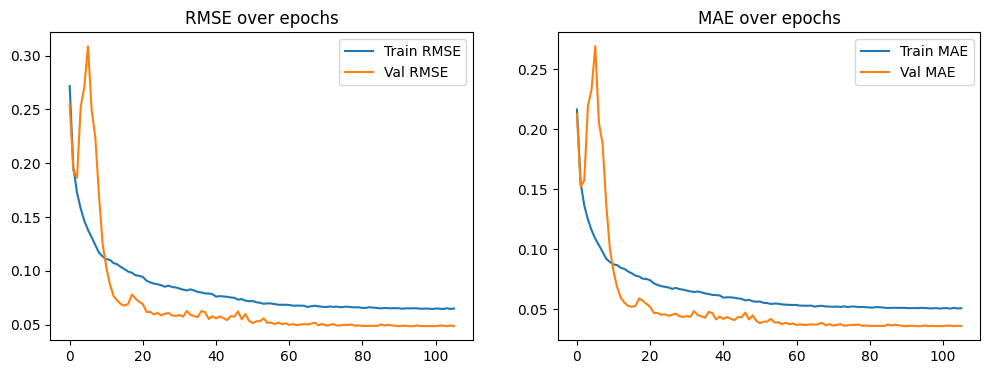

In [50]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Val RMSE')
plt.legend()
plt.title('RMSE over epochs')

plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.title('MAE over epochs')

plt.show()

14/14 [==============================] - 0s 22ms/step


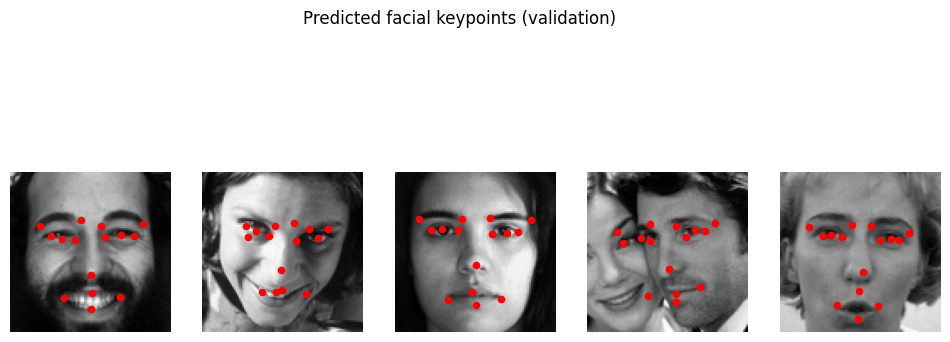

In [51]:
y_val_pred = model.predict(x_val)

plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image_with_keypoints(x_val[i], y_val_pred[i])
plt.suptitle('Predicted facial keypoints (validation)')
plt.show()

In [52]:
final_model=tf.keras.models.clone_model(model)

In [53]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.MSE,metrics=[rmse, tf.keras.metrics.MAE])

In [54]:
final_model.fit(x_c, y_c,epochs=94,batch_size=32,verbose=1)

Epoch 1/94


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

 7/67 [==>...........................] - ETA: 1s - loss: 0.2541 - rmse: 0.4625 - mean_absolute_error: 0.3746  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


66/67 [============================>.] - ETA: 0s - loss: 0.1258 - rmse: 0.2941 - mean_absolute_error: 0.2355

W0000 00:00:1766943644.713228     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.713701     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.714053     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.714615     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.715068     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.716140     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.716880     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.717663     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.718211     533 gp

67/67 [==============================] - 3s 18ms/step - loss: 0.1253 - rmse: 0.2931 - mean_absolute_error: 0.2347
Epoch 2/94
11/67 [===>..........................] - ETA: 0s - loss: 0.0821 - rmse: 0.2197 - mean_absolute_error: 0.1740

W0000 00:00:1766943644.914361     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.916193     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.918246     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.920891     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.922761     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.931246     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.931650     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.931990     534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943644.932408     534 gp

63/67 [===========================>..] - ETA: 0s - loss: 0.0755 - rmse: 0.2041 - mean_absolute_error: 0.1620

W0000 00:00:1766943645.841340     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.841770     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.842114     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.842592     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.843037     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.843919     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.844677     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.845472     531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943645.846020     531 gp

67/67 [==============================] - 1s 16ms/step - loss: 0.0753 - rmse: 0.2035 - mean_absolute_error: 0.1615
Epoch 3/94
10/67 [===>..........................] - ETA: 0s - loss: 0.0667 - rmse: 0.1821 - mean_absolute_error: 0.1447

W0000 00:00:1766943646.044606     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.065244     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


67/67 [==============================] - 1s 14ms/step - loss: 0.0644 - rmse: 0.1758 - mean_absolute_error: 0.1392
Epoch 4/94
 9/67 [===>..........................] - ETA: 0s - loss: 0.0603 - rmse: 0.1644 - mean_absolute_error: 0.1296

W0000 00:00:1766943646.947074     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.947579     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.948269     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.948860     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.949495     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.950329     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.951185     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.952030     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943646.953162     533 gp

67/67 [==============================] - 1s 13ms/step - loss: 0.0585 - rmse: 0.1594 - mean_absolute_error: 0.1260
Epoch 5/94
 9/67 [===>..........................] - ETA: 0s - loss: 0.0551 - rmse: 0.1487 - mean_absolute_error: 0.1167

W0000 00:00:1766943647.856273     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.856740     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.857411     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.857979     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.858575     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.859356     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.860141     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.860941     532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766943647.861986     532 gp

67/67 [==============================] - 1s 13ms/step - loss: 0.0541 - rmse: 0.1459 - mean_absolute_error: 0.1151
Epoch 6/94
67/67 [==============================] - 1s 13ms/step - loss: 0.0513 - rmse: 0.1374 - mean_absolute_error: 0.1082
Epoch 7/94
67/67 [==============================] - 1s 13ms/step - loss: 0.0486 - rmse: 0.1285 - mean_absolute_error: 0.1013
Epoch 8/94
67/67 [==============================] - 1s 13ms/step - loss: 0.0465 - rmse: 0.1216 - mean_absolute_error: 0.0957
Epoch 9/94
67/67 [==============================] - 1s 12ms/step - loss: 0.0450 - rmse: 0.1167 - mean_absolute_error: 0.0918
Epoch 10/94
67/67 [==============================] - 1s 13ms/step - loss: 0.0432 - rmse: 0.1105 - mean_absolute_error: 0.0872
Epoch 11/94
67/67 [==============================] - 1s 13ms/step - loss: 0.0420 - rmse: 0.1072 - mean_absolute_error: 0.0844
Epoch 12/94
67/67 [==============================] - 1s 12ms/step - loss: 0.0407 - rmse: 0.1029 - mean_absolute_error: 0.0810
Epoch 13

In [56]:
final_model.save('final_keypoints_cnn.keras')

In [57]:
with open('target_cols.json', 'w') as f:
    json.dump(target_cols, f)

In [58]:
preprocess_config={
    'img_size': [96, 96],
    'normalize': 'x / 255.0',
    'target_normalization': '(y - 48) / 48'
}

with open('preprocess_config.json', 'w') as f:
    json.dump(preprocess_config, f)

In [59]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

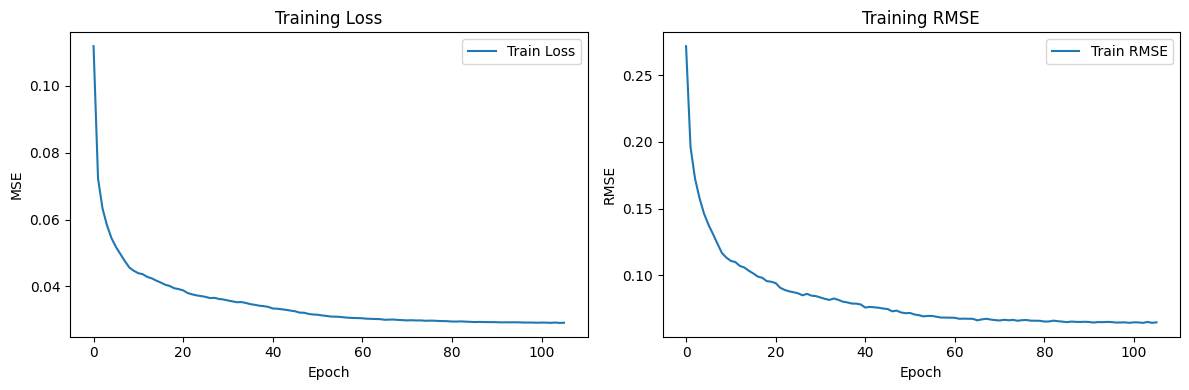

In [60]:
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# RMSE
plt.subplot(1,2,2)
plt.plot(history.history['rmse'], label='Train RMSE')
plt.title('Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

The training loss decreases steadily over epochs, showing stable and effective learning without signs of divergence.

The training RMSE drops consistently and converges, indicating improving keypoint prediction accuracy over time.

1/1 [==============================] - 0s 245ms/step


W0000 00:00:1766945038.163182     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.163783     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.163974     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.164265     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.164470     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.164999     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.165230     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.165453     533 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945038.165758     533 gp

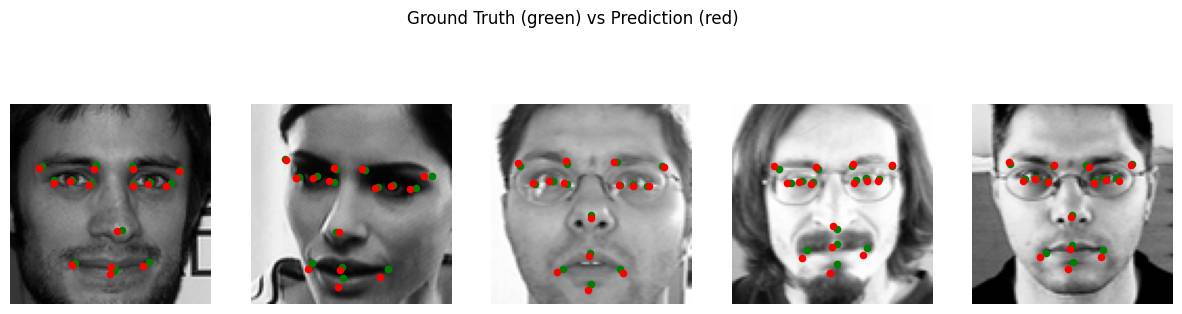

In [61]:
idx = np.random.choice(len(x_c), 5, replace=False)

pred = final_model.predict(x_c[idx])
pred = pred * 48 + 48
gt = y_c[idx] * 48 + 48

plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_c[idx[i]].squeeze(), cmap='gray')

    plt.scatter(gt[i][0::2], gt[i][1::2], c='green', s=20, label='GT')
    plt.scatter(pred[i][0::2], pred[i][1::2], c='red', s=20, label='Pred')
    plt.axis('off')

plt.suptitle('Ground Truth (green) vs Prediction (red)')
plt.show()

Predicted keypoints (red) closely align with the ground truth (green), demonstrating strong spatial accuracy across facial features.

The model generalizes well to different faces and expressions, with most keypoints correctly localize

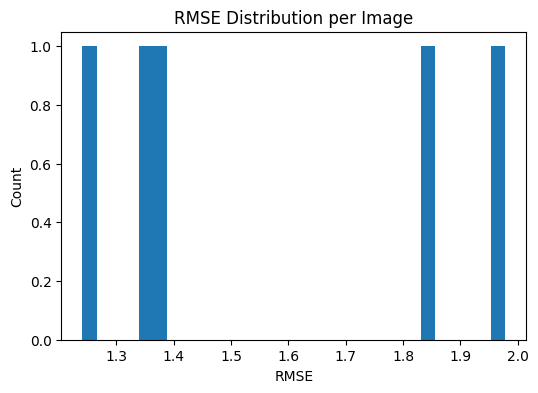

In [62]:
errors = np.sqrt(np.mean((pred - gt)**2, axis=1))

plt.figure(figsize=(6,4))
plt.hist(errors, bins=30)
plt.title('RMSE Distribution per Image')
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.show()

Most images have low RMSE values, while a small number of harder samples show higher errors.

### Final Model Inference on Test Data

In [64]:
submission = lookup_df.copy()

In [65]:
print(submission['ImageId'].min(), submission['ImageId'].max())

1 1783


In [68]:
def parse_image(img_str):
    pixels = np.fromstring(img_str, sep=' ',dtype=np.float32)
    return pixels.reshape(96, 96, 1)

In [69]:
x_test=np.stack(test_df['Image'].apply(parse_image).values)

In [70]:
x_test=x_test / 255.0
print(x_test.shape)

(1783, 96, 96, 1)


In [71]:
y_test_pred=model.predict(x_test, batch_size=32)
print(y_test_pred.shape)

56/56 [==============================] - 1s 9ms/step
(1783, 30)


W0000 00:00:1766945733.552945     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.555958     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.556202     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.556589     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.556942     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.557548     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.558136     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.558772     536 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1766945733.559172     536 gp

In [72]:
y_test_pred=y_test_pred * 48 + 48

In [73]:
feature_to_idx={f: i for i, f in enumerate(target_cols)}

submission['Location']=[y_test_pred[row.ImageId - 1, feature_to_idx[row.FeatureName]]for row in submission.itertuples()]

In [75]:
print(submission.head())
print(submission.shape)
print(submission['Location'].isna().sum())
print(submission['Location'].describe())

   RowId  ImageId              FeatureName   Location
0      1        1        left_eye_center_x  67.159271
1      2        1        left_eye_center_y  38.925602
2      3        1       right_eye_center_x  28.235607
3      4        1       right_eye_center_y  34.146210
4      5        1  left_eye_inner_corner_x  61.096382
(27124, 4)
0
count    27124.000000
mean        48.627544
std         17.872271
min          5.656898
25%         35.362759
50%         45.751131
75%         62.926924
max        102.183228
Name: Location, dtype: float64


In [76]:
print(submission['Location'].isna().sum())
submission.head()

0


,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,67.159271
1,2,1,left_eye_center_y,38.925602
2,3,1,right_eye_center_x,28.235607
3,4,1,right_eye_center_y,34.146210
4,5,1,left_eye_inner_corner_x,61.096382


In [77]:
submission.to_csv('submission.csv',index=False)

In [78]:
print(submission.shape)            # (27124, 4)
print(submission.isna().sum())     # überall 0
print(submission.head())

(27124, 4)
RowId          0
ImageId        0
FeatureName    0
Location       0
dtype: int64
   RowId  ImageId              FeatureName   Location
0      1        1        left_eye_center_x  67.159271
1      2        1        left_eye_center_y  38.925602
2      3        1       right_eye_center_x  28.235607
3      4        1       right_eye_center_y  34.146210
4      5        1  left_eye_inner_corner_x  61.096382


In [79]:
submission.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,67.159271
1,2,1,left_eye_center_y,38.925602
2,3,1,right_eye_center_x,28.235607
3,4,1,right_eye_center_y,34.146210
4,5,1,left_eye_inner_corner_x,61.096382


In [81]:
final_submission=submission[['RowId', 'Location']].copy()

In [82]:
print(final_submission.head())
print(final_submission.shape)
print(final_submission.isna().sum())

   RowId   Location
0      1  67.159271
1      2  38.925602
2      3  28.235607
3      4  34.146210
4      5  61.096382
(27124, 2)
RowId       0
Location    0
dtype: int64


In [83]:
final_submission.to_csv('submission.csv', index=False)

### Conclusion

In this project, a custom CNN was successfully trained to predict facial keypoints with high accuracy.
The model showed stable training behavior, with steadily decreasing loss and RMSE values.
Both quantitative metrics (RMSE and MAE) and qualitative visualizations confirm that the predicted keypoints closely match the ground truth locations.
Visual inspections of test images demonstrate that the model correctly identifies key facial structures such as the eyes, nose, and mouth across different faces.
The final predictions contained no missing values, and a valid submission file was generated for the test dataset.
The trained model, preprocessing configuration, and feature mappings were saved and used to build a Streamlit application for interactive inference.
Overall, this project demonstrates a complete and well-structured CNN-based regression pipeline, from raw data to deployment-ready results.